In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

import os
import sys

## 2. Generalization Across Subjects

In [2]:
def build_dataset_from_ninapro(_emg, _stimulus, _repetition, features=None, feature_norm=False):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    _n_stimuli = len(np.unique(_stimulus)) - 1
    _n_repetitions = len(np.unique(_repetition)) - 1
    # Total number of samples is the product of stimuli and repetitions
    _n_samples = _n_stimuli * _n_repetitions

    # Number of channels in the EMG data
    _n_channels = _emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(_n_channels for feature in features)

    # Initialize the dataset and labels arrays with zeros
    _dataset = np.zeros((_n_samples, n_features))
    _labels = np.zeros(_n_samples)
    current_sample_index = 0

    # Loop over each stimulus and repetition to extract features
    for i in range(_n_stimuli):
        for j in range(_n_repetitions):
            # Assign the label for the current sample
            _labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * _n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(_stimulus == i + 1, _repetition == j + 1).squeeze()

            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + _n_channels)
                # Apply the feature function to the selected EMG data and store the result
                cur_feature = feature(_emg[selected_tsteps, :])
                _dataset[current_sample_index, selected_features] = cur_feature
                # Update the feature index for the next feature
                current_feature_index += _n_channels

            # Move to the next sample
            current_sample_index += 1
    if feature_norm:
        _dataset = (_dataset - _dataset.min(axis=0)) / (_dataset.max(axis=0) - _dataset.min(axis=0))
    
    # Return the constructed dataset and corresponding labels
    return _dataset, _labels

In [3]:
# Define the features
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)
# Zero Crossing (ZC)
zc = lambda x: np.sum((x[:-1, :] * x[1:, :]) < 0, axis=0)

### 2.1. Load EMG data of all 27 subjects, and perform the same preprocessing pipeline

In [4]:
dataset_all = np.zeros((0, 60))
labels_all = np.zeros((0,))

for sub_idx in range(1, 27+1):

    # 1. Load data

    print('---- Loading Data From {sub_idx}')
    EMG_file_name = f's{sub_idx}/S{sub_idx}_A1_E1.mat'
    emg_data = loadmat(EMG_file_name)
    emg = emg_data["emg"].copy()
    stimulus = emg_data["restimulus"]
    repetition = emg_data["rerepetition"]
    print(f'    EMG: {emg.shape}, Stimulus {stimulus.shape}, Repetition {repetition.shape}')

    # 2. Perform bandpass filtering

    fs = 100  # Sampling frequency in Hz
    low_cutoff_frequency = 5  # Highpass filter cutoff frequency in Hz
    
    # Step 1: Highpass filter to remove low-frequency waves
    sos_highpass = butter(N=0, Wn=low_cutoff_frequency, fs=fs, btype="highpass", output="sos")
    emg_filtered = sosfiltfilt(sos_highpass, emg.T).T  # Apply highpass filter
    
    # Step 2: Bandstop filters to remove 50 Hz and its harmonics
    powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)]  # Add harmonics if needed, e.g., [50, 100]
    
    for noise_frequency in powergrid_noise_frequencies_Hz:
        if noise_frequency < fs / 2:  # Ensure frequency is below Nyquist frequency
            sos_bandstop = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), 
                                  fs=fs, btype="bandstop", output="sos")
            emg_filtered = sosfiltfilt(sos_bandstop, emg_filtered.T).T

    # 3. Moving average
    mov_mean_size = 200
    mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size

    dataset, labels = build_dataset_from_ninapro(
        _emg=emg_filtered,
        _stimulus=stimulus,
        _repetition=repetition,
        features=[mav, std, maxav, rms, wl, ssc],
        feature_norm=True
    )
    # Reshape so that each row is all 720 features (motion=12 x feature=6 x channels=10) of 1 subject
    dataset_all = np.vstack((dataset_all, dataset))
    labels_all = np.hstack((labels_all, labels))


---- Loading Data From {sub_idx}
    EMG: (101014, 10), Stimulus (101014, 1), Repetition (101014, 1)
---- Loading Data From {sub_idx}
    EMG: (100686, 10), Stimulus (100686, 1), Repetition (100686, 1)
---- Loading Data From {sub_idx}
    EMG: (100720, 10), Stimulus (100720, 1), Repetition (100720, 1)
---- Loading Data From {sub_idx}
    EMG: (100835, 10), Stimulus (100835, 1), Repetition (100835, 1)
---- Loading Data From {sub_idx}
    EMG: (100894, 10), Stimulus (100894, 1), Repetition (100894, 1)
---- Loading Data From {sub_idx}
    EMG: (101083, 10), Stimulus (101083, 1), Repetition (101083, 1)
---- Loading Data From {sub_idx}
    EMG: (100817, 10), Stimulus (100817, 1), Repetition (100817, 1)
---- Loading Data From {sub_idx}
    EMG: (100854, 10), Stimulus (100854, 1), Repetition (100854, 1)
---- Loading Data From {sub_idx}
    EMG: (100925, 10), Stimulus (100925, 1), Repetition (100925, 1)
---- Loading Data From {sub_idx}
    EMG: (100778, 10), Stimulus (100778, 1), Repetition (1

### 2.2. Extract the same set of features, look at the values across different subjects.

dataset dimension: (3240, 60)
labels dimension: (3240,)


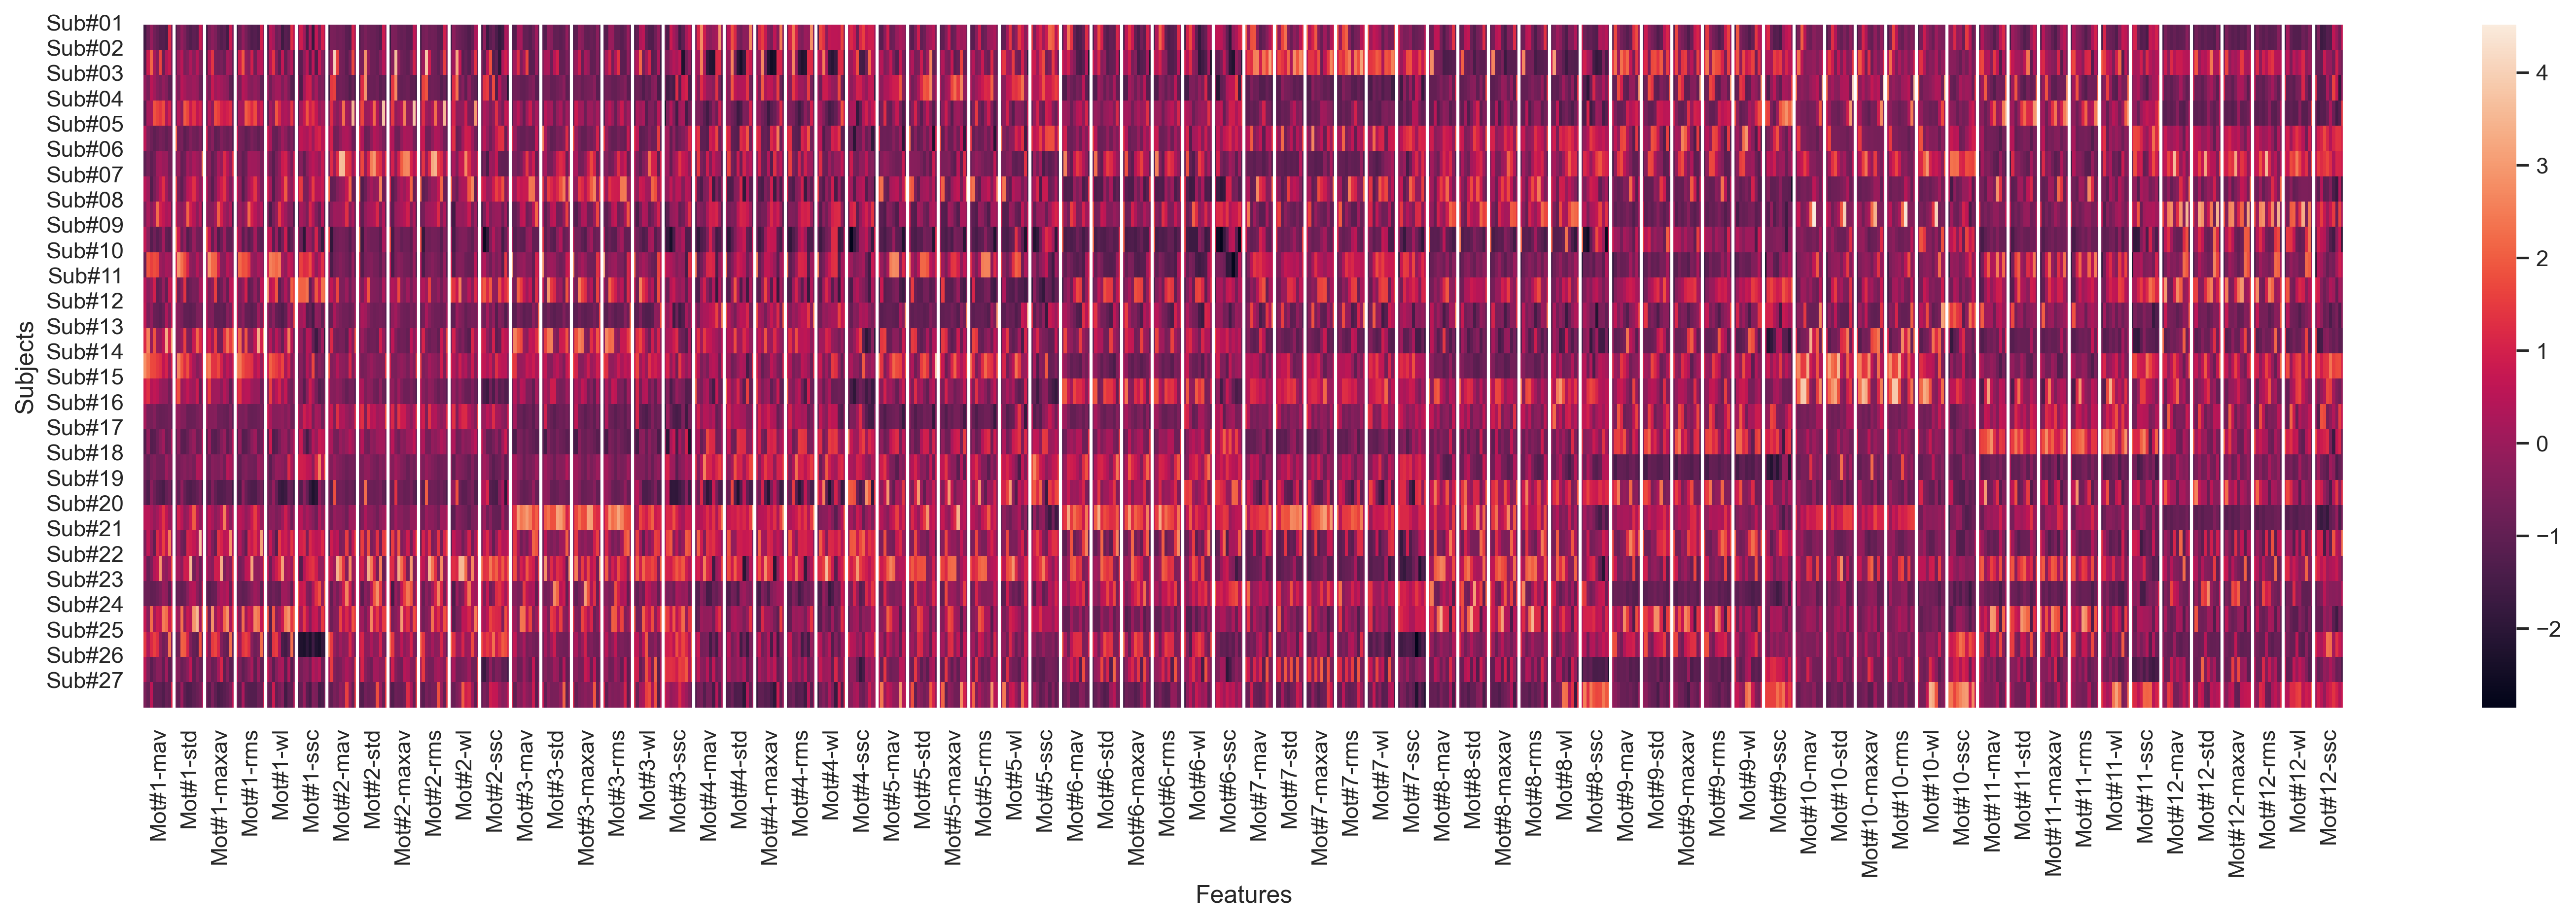

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

print(f"dataset dimension: {dataset_all.shape}")
print(f"labels dimension: {labels_all.shape}")
# Average across repetitions
dataset_all_rep_avg = np.array([dataset_all[rep_idx*10:(rep_idx+1)*10, :].mean(axis=0) for rep_idx in range(12*27)])
# Reshape so that each row is all 720 features (motion=12 x feature=6 x channels=10) of 1 subject
dataset_all_rep_avg = np.array([dataset_all_rep_avg[sub_idx*12:(sub_idx+1)*12].reshape(-1) for sub_idx in range(27)])
scaler = StandardScaler()
dataset_all_std = scaler.fit_transform(dataset_all_rep_avg)

plt.figure(figsize=(24, 6), dpi=300)
sns.heatmap(dataset_all_std)
plt.xlabel('Features')
plt.ylabel('Subjects')
plt.yticks(range(27), [f'Sub#%02d' % (x+1) for x in range(27)], rotation=0)
feature_list = ['mav', 'std', 'maxav', 'rms', 'wl', 'ssc']
plt.xticks(range(5, 716, 10), [f'Mot#{mot_idx+1}-{feature}' for mot_idx in range(12) for feature in feature_list])
ax = plt.gca()
for x in range(10, dataset_all.shape[0], 10):  # 每隔10个特征
    ax.axvline(x=x, color='white', linestyle='-', linewidth=1.5)

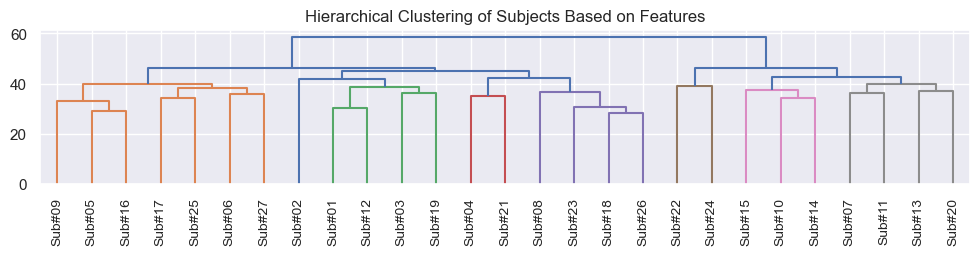

In [6]:
# Clustering of Subjects
linked = linkage(dataset_all_std, method='ward')
plt.figure(figsize=(12, 2))
dendrogram(linked, labels=[f'Sub#%02d' % (x+1) for x in range(27)], leaf_rotation=90)
plt.title('Hierarchical Clustering of Subjects Based on Features')
plt.show()

### 2.3. Train a classification model on 26 subjects, and test it on a subject outside the train set.

**Generate dataset and select features**

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()

#Train:Validation:Test=70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(dataset_all, labels_all, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train_z = np.nan_to_num(scaler.fit_transform(X_train))
X_val_z = np.nan_to_num(scaler.transform(X_val))
X_test_z = np.nan_to_num(scaler.transform(X_test))
print(f'n_training: {X_train_z.shape[0]}, n_validation: {X_val_z.shape[0]}, n_test: {X_test_z.shape[0]}')

n_training: 2268, n_validation: 486, n_test: 486


In [18]:
# Calculate mutual information between each feature and the target variable.
# Mutual information is a measure of the dependency between variables.
# A higher value indicates a stronger relationship.
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

best_k = 22
k_best = SelectKBest(mutual_info_classif, k=best_k)
k_best.fit(X_train_z, y_train)

# Transform the training and test datasets to only include the selected features.
dataset_all_red = k_best.transform(dataset_all)

Estimated mutual information between each feature and the target:
 [0.05890535 0.1022509  0.12137751 0.11043117 0.14301858 0.17377846
 0.31275418 0.08156388 0.16384135 0.16615806 0.05751534 0.13124697
 0.13998933 0.10901047 0.14862513 0.16788714 0.26577021 0.12842945
 0.177407   0.18882213 0.09541106 0.09153151 0.13093868 0.09390918
 0.14838823 0.19080521 0.26526704 0.087224   0.19492721 0.1838783
 0.04034459 0.11703371 0.1178306  0.13894711 0.11175405 0.21290549
 0.28232417 0.10072558 0.18015414 0.17088361 0.01416677 0.09947468
 0.10583444 0.14698312 0.12319505 0.19702204 0.30367457 0.08529044
 0.15775268 0.18353643 0.04478001 0.0403125  0.0389411  0.11944381
 0.08917388 0.13978352 0.13684686 0.02847393 0.06945378 0.1205787 ]



**Train on 26 subjects and test on 1**

In [ ]:
n_subjects = 27
samples_per_subject = 120
sub_idx = 2  # Which specific subject to test on
test_mask = np.zeros((dataset_all_red.shape[0],), dtype=bool)
test_mask[(sub_idx-1)*120: sub_idx*120] = 1

X_train = dataset_all_red[~test_mask, :]
y_train = labels_all[~test_mask]
X_test = dataset_all_red[test_mask, :]
y_test = labels_all[test_mask]

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

# Standardization before training
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z = scaler.transform(X_test)

clf = GradientBoostingClassifier(n_estimators=200, max_depth=4, learning_rate=0.01, random_state=42, min_samples_split=2, min_samples_leaf=4)
X_train_z = np.nan_to_num(X_train_z)
clf.fit(X_train_z, y_train)

X_test_z = np.nan_to_num(X_test_z)
y_pred = clf.predict(X_test_z)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score on subject {sub_idx}: {accuracy}")

confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix for Subject 27")
plt.show()


Training data shape: (3120, 22), Testing data shape: (120, 22)


## Code for Leave-One-Subject-Out Cross-Validation (LOSO-CV)

In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Number of subjects and samples per subject
n_subjects = 27
samples_per_subject = 120  # Each subject has 120 samples

# Assuming dataset and labels are provided
# dataset: shape (n_subjects * samples_per_subject, n_features)
# labels: shape (n_subjects * samples_per_subject,)

# Placeholder for results
accuracy_list = []

# Create a folder to save the confusion matrix images
output_folder = "confusion_matrices"
os.makedirs(output_folder, exist_ok=True)

# Leave-One-Subject-Out Cross-Validation
for test_subject in range(n_subjects):
    print(f"\nFold {test_subject + 1}: Testing on Subject {test_subject + 1}")

    # Define train and test indices
    test_start = test_subject * samples_per_subject
    test_end = test_start + samples_per_subject

    X_test = dataset_all[test_start:test_end, :]
    y_test = labels_all[test_start:test_end]

    X_train = np.delete(dataset_all, np.s_[test_start:test_end], axis=0)  # Remove test subject
    y_train = np.delete(labels_all, np.s_[test_start:test_end], axis=0)   # Remove test subject labels

    # Standardize the data
    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    # Train the model
    clf = GradientBoostingClassifier(n_estimators=200, max_depth=4, learning_rate=0.01, random_state=42, min_samples_split=2, min_samples_leaf=4)
    clf.fit(X_train_z, y_train)

    # Predict and evaluate
    y_pred = clf.predict(X_test_z)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

    print(f"Accuracy for Subject {test_subject + 1}: {accuracy:.4f}")

    # Confusion matrix for the current fold (optional visualization)
    confmat = confusion_matrix(y_test, y_pred, normalize="true")
    plt.figure(figsize=(6, 5))
    sns.heatmap(confmat, annot=True, cmap="Blues")
    plt.title(f"Confusion Matrix for Subject {test_subject + 1}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

    # Save confusion matrix image
    save_path = os.path.join(output_folder, f"confusion_matrix_subject_{test_subject + 1}.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.close()
    print(f"Confusion matrix saved to: {save_path}")

# Final evaluation
average_accuracy = np.mean(accuracy_list)
print("\nFinal Evaluation Across All Folds:")
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Accuracies for Each Fold: {accuracy_list}")



Fold 1: Testing on Subject 1
Accuracy for Subject 1: 0.4083
Confusion matrix saved to: confusion_matrices\confusion_matrix_subject_1.png

Fold 2: Testing on Subject 2
Accuracy for Subject 2: 0.1250
Confusion matrix saved to: confusion_matrices\confusion_matrix_subject_2.png

Fold 3: Testing on Subject 3
Accuracy for Subject 3: 0.3833
Confusion matrix saved to: confusion_matrices\confusion_matrix_subject_3.png

Fold 4: Testing on Subject 4
Accuracy for Subject 4: 0.3667
Confusion matrix saved to: confusion_matrices\confusion_matrix_subject_4.png

Fold 5: Testing on Subject 5


In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os

# Number of subjects and samples per subject
n_subjects = 27
samples_per_subject = 120  # Each subject has 120 samples

# Placeholder for accuracy results
accuracy_list = []
train_subject_counts = list(range(1, n_subjects))  # Train using 1, 2, ..., 26 subjects

# Test set: Subject 27
test_subject = n_subjects - 1  # Index of subject 27
test_start = test_subject * samples_per_subject
test_end = test_start + samples_per_subject
X_test = dataset_all[test_start:test_end, :]
y_test = labels_all[test_start:test_end]

# Output directory for saving images
output_folder = "accuracy_plots"
os.makedirs(output_folder, exist_ok=True)

# Loop to vary the number of training subjects
for num_train_subjects in train_subject_counts:
    print(f"\nTraining with {num_train_subjects} subjects")

    # Define training data (subjects 1 to num_train_subjects)
    train_end = num_train_subjects * samples_per_subject
    X_train = dataset_all[:train_end, :]
    y_train = labels_all[:train_end]

    # Standardize the data
    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    # Train the model
    clf = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    clf.fit(X_train_z, y_train)

    # Predict on test data (subject 27)
    y_pred = clf.predict(X_test_z)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

    print(f"Accuracy with {num_train_subjects} subjects: {accuracy:.4f}")

# Plot accuracy trend
plt.figure(figsize=(8, 6))
plt.plot(train_subject_counts, accuracy_list, marker='o', linestyle='-')
plt.xlabel("Number of Training Subjects")
plt.ylabel("Accuracy on Test Subject 27")
plt.title("Impact of Training Set Size on Classification Performance")
plt.grid()

# Save the accuracy plot
plot_save_path = os.path.join(output_folder, "accuracy_trend_subject27.png")
plt.savefig(plot_save_path, bbox_inches="tight", dpi=300)
plt.show()
print(f"Accuracy trend plot saved to: {plot_save_path}")

# Summary of Results
print("Final Results:")
for i, acc in enumerate(accuracy_list):
    print(f"Training with {i+1} subjects: Accuracy = {acc:.4f}")
